# A Study of Potential Influencing Factors on Canadian Immigrants.
### CSCI 6405 -- Data Mining Project, Dalhousie University.
### By Hongwei Zhang, January - April 2023.

## Experiment 1: Study the reasons for Canadian immigrants leaving their home countries based on economic and social indicators for their countries.
### Data mining methods: Kmeans Clustering, Hierarchical Clustering
### Datasets used: The number of immigrants in Canada by country in the past ten years (2011-2021), and the economic and social indicators of the corresponding countries.

In [22]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_samples, silhouette_score

In [23]:
# Organizing and processing Canadian immigration dataset.
im = pd.read_csv("Datasets/immigrants.csv", skiprows=14, nrows=215)
im.columns=['Birthplace', '1980-1990', '1991-2000', '2001-2010', '2011-2021']

for i in range(len(im)):
    if im['Birthplace'][i][-2:].isdigit():
        im['Birthplace'][i] = im['Birthplace'][i][0:-3]
    if im['Birthplace'][i][-1].isdigit():
        im['Birthplace'][i] = im['Birthplace'][i][0:-2]

    im['1980-1990'][i] = int(im['1980-1990'][i].replace(',', ''))
    im['1991-2000'][i] = int(im['1991-2000'][i].replace(',', ''))
    im['2001-2010'][i] = int(im['2001-2010'][i].replace(',', ''))
    im['2011-2021'][i] = int(im['2011-2021'][i].replace(',', ''))
    if im['1980-1990'][i] == 0 and im['1991-2000'][i] == 0 and im['2001-2010'][i] == 0 and im['2011-2021'][i] == 0:
        im=im.drop(labels=i)

im = im.sort_values(by=['Birthplace'])
im.reset_index(drop=True, inplace=True)

print("Number of country/region:", len(im))
im.head()

Number of country/region: 200


,Birthplace,1980-1990,1991-2000,2001-2010,2011-2021
0,Afghanistan,3920,14745,22280,21340
1,Albania,15,4130,8000,5500
2,Algeria,1345,11745,32430,32580
3,Andorra,0,0,0,30
4,Angola,415,390,1315,580


In [24]:
# Filtering data from each dataset for 2011 and 2021.
'''
Dataset name and meaning:
gdp: GDP per capita (current US$), GDP11 = GDP per capita for 2011, GDP21 = GDP per capita for 2021.
life: Life expectancy at birth, total (years), LE11, LE21.
inflation: Inflation, consumer prices (annual %), IF11, IF21.
employment: Employment to population ratio, 15+, total (%), EM11, EM21.
female: Labor force participation rate, female (% of female population ages 15+), FM11, FM21.
health: Current health expenditure (% of GDP), HE11, HE21.
education: Government expenditure on education, total (% of GDP), ED11, ED21.
'''

gdp = pd.read_csv("Datasets/gdp.csv", skiprows=4, nrows=266, usecols=[0, 55, 65])
gdp.columns = ['Birthplace', 'GDP11', 'GDP21']
life = pd.read_csv("Datasets/life.csv", skiprows=4, usecols=[55, 65])
life.columns = ['LE11', 'LE21']
inflation = pd.read_csv("Datasets/inflation.csv", skiprows=4, usecols=[55, 65])
inflation.columns = ['IF11', 'IF21']
employment = pd.read_csv("Datasets/employment.csv", skiprows=4, usecols=[55, 65])
employment.columns = ['EM11', 'EM21']
female = pd.read_csv("Datasets/female.csv", skiprows=4, usecols=[55, 65])
female.columns = ['FM11', 'FM21']
health = pd.read_csv("Datasets/health.csv", skiprows=4, usecols=[55, 65])
health.columns = ['HE11', 'HE21']
education = pd.read_csv("Datasets/education.csv", skiprows=4, usecols=[55, 65])
education.columns = ['ED11', 'ED21']

comb = pd.concat([gdp, life, inflation, employment, female, health, education], axis=1)
print("Number of country/region:", len(comb))
comb.head()

Number of country/region: 266


,Birthplace,GDP11,GDP21,LE11,LE21,IF11,IF21,EM11,EM21,FM11,FM21,HE11,HE21,ED11,ED21
0,Aruba,26044.435933,29342.100858,75.465000,NaN,4.316297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.11913,NaN
1,Africa Eastern and Southern,1792.847428,1537.336021,59.293271,NaN,8.971206,6.079328,65.610090,64.030243,64.596561,64.434443,6.774233,NaN,4.38598,NaN
2,Afghanistan,621.912311,368.754614,61.419000,NaN,11.804186,NaN,43.180000,NaN,15.784000,NaN,8.561907,NaN,3.46201,NaN
3,Africa Western and Central,1856.687669,1757.030626,55.013138,NaN,4.018699,3.837868,61.222896,58.388407,57.979904,54.091940,3.547476,NaN,2.66890,NaN
4,Angola,4511.153227,1953.533757,57.596000,NaN,13.482468,25.754266,71.628998,68.557999,74.873001,74.463997,2.645608,NaN,3.03000,NaN


In [25]:
# Use the data imputation algorithm to fill in the missing data.

def imputation (file, data, col1, col2):  # csv file, table, index of the two columns need to be filled.
    f = pd.read_csv(file, skiprows=4, usecols=range(35, 66)).to_numpy()  # 1991-2021

    for i in range(len(data)):
        # Find the location of the missing data and read all data from the dataset for a certain time range.
        if math.isnan(data.iloc[[i], [col1]].values) or math.isnan(data.iloc[[i], [col2]].values):
            row = []
            for j in f[i]:
                if not math.isnan(j):
                    row.append(j)

            # If there are more than ten data exist, choose two data that are ten years apart.
            if len(row) >= 10:
                data.iloc[[i], [col1]] = row[len(row) - 10]
                data.iloc[[i], [col2]] = row[-1]

            # Otherwise, select the first and last one.
            elif 1 < len(row) < 10:
                data.iloc[[i], [col1]] = row[0]
                data.iloc[[i], [col2]] = row[-1]
            row.clear()


imputation("Datasets/gdp.csv", comb, 1, 2)
imputation("Datasets/life.csv", comb, 3, 4)
imputation("Datasets/inflation.csv", comb, 5, 6)
imputation("Datasets/employment.csv", comb, 7, 8)
imputation("Datasets/female.csv", comb, 9, 10)
imputation("Datasets/health.csv", comb, 11, 12)
imputation("Datasets/education.csv", comb, 13, 14)

# For countries or regions with too much missing data, they are removed because they cannot be imputed.
comb.dropna(axis=0,subset = ['GDP11', 'GDP21', 'LE11', 'LE21', 'IF11', 'IF21', 'EM11', 'EM21', 'FM11', 'FM21', 'HE11', 'HE21', 'ED11', 'ED21'], inplace=True)
comb = comb.sort_values(by=['Birthplace'])
comb.reset_index(drop=True, inplace=True)

print("Number of country/region:", len(comb))
comb.head()

Number of country/region: 215


,Birthplace,GDP11,GDP21,LE11,LE21,IF11,IF21,EM11,EM21,FM11,FM21,HE11,HE21,ED11,ED21
0,Afghanistan,621.912311,368.754614,61.419000,62.575000,2.178538,2.302373,43.180000,36.710999,15.784000,16.462999,8.569672,13.242202,3.46201,2.860859
1,Africa Eastern and Southern,1792.847428,1537.336021,59.293271,63.313856,8.971206,6.079328,65.610090,64.030243,64.596561,64.434443,6.923020,6.272034,4.38598,4.608170
2,Africa Western and Central,1856.687669,1757.030626,55.013138,57.226373,4.018699,3.837868,61.222896,58.388407,57.979904,54.091940,3.519651,3.366086,2.66890,3.173885
3,Albania,4437.142612,6492.872012,78.092000,76.989000,3.429123,2.041472,51.860001,51.367001,52.467999,51.653000,4.602225,5.232072,3.08000,3.100000
4,Algeria,5473.280550,3690.627878,74.123000,74.453000,4.524212,7.226063,37.686001,35.349998,14.861000,15.909000,5.117172,6.243371,6.03000,7.042397


In [26]:
# Generate the dataset to be used.
a0, a1, a2, a3, a4, a5, a6, a7, a8 = [], [], [], [], [], [], [], [], []
for m in range(len(comb)):
    for n in range(len(im)):
        if comb['Birthplace'][m] == im['Birthplace'][n]:
            a0.append(im['Birthplace'][n])
            a1.append(im['2011-2021'][n])
            a2.append(comb['GDP11'][m])
            a3.append(comb['LE11'][m])
            a4.append(comb['IF11'][m])
            a5.append(comb['EM11'][m])
            a6.append(comb['FM11'][m])
            a7.append(comb['HE11'][m])
            a8.append(comb['ED11'][m])

dataset = pd.DataFrame({'Birthplace':a0, 'Immigration':a1, 'GDP':a2,
                        'LE':a3, 'IF':a4, 'EM':a5,
                        'FM':a6, 'HE':a7, 'ED':a8})
print("Number of country/region:", len(dataset))
dataset.head()

Number of country/region: 138


,Birthplace,Immigration,GDP,LE,IF,EM,FM,HE,ED
0,Afghanistan,21340,621.912311,61.419,2.178538,43.180000,15.784000,8.569672,3.46201
1,Albania,5500,4437.142612,78.092,3.429123,51.860001,52.467999,4.602225,3.08000
2,Algeria,32580,5473.280550,74.123,4.524212,37.686001,14.861000,5.117172,6.03000
3,Angola,580,4511.153227,57.596,13.482468,71.628998,74.873001,2.695100,3.03000
4,Armenia,2120,3462.681611,73.305,7.650008,54.722000,55.479000,9.235391,3.14385


In [27]:
dataset.describe()

,Immigration,GDP,LE,IF,EM,FM,HE,ED
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,14225.905797,14776.610053,70.183486,6.547505,56.747703,50.575101,6.202799,4.452704
std,48054.114520,21818.564156,9.026124,6.920245,11.345489,14.644289,2.449967,2.354510
min,10.000000,236.451354,46.692000,-0.400041,24.028000,11.981000,1.870178,0.466384
25%,883.750000,1498.715963,63.282250,3.299550,49.800500,43.578251,4.221904,3.065432
50%,2822.500000,5434.964988,72.403000,4.974611,57.022501,52.403999,6.000268,4.370625
75%,7415.000000,16383.624312,76.931152,7.823345,63.371250,58.748500,8.219783,5.539615
max,390965.000000,119025.057203,82.695122,53.228698,86.007004,83.807999,11.276376,22.322210


<Axes: >

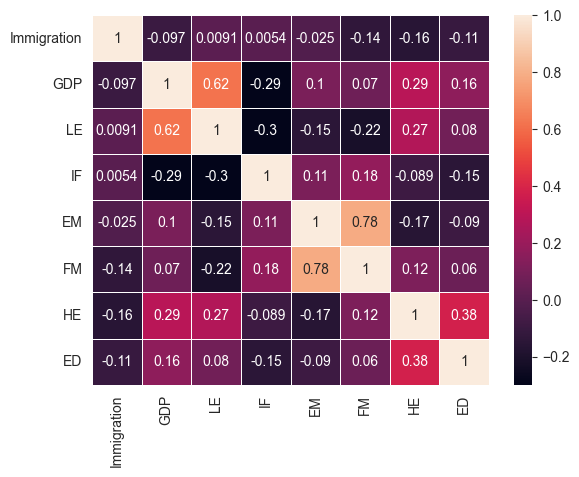

In [28]:
# Generate correlation coefficient heat map.
corr = dataset.corr(numeric_only=True)
sb.heatmap(corr, annot=True, linewidth=0.5)

[Text(0.5, 0, 'Government expenditure on education'),
 Text(0, 0.5, 'Country or Region')]

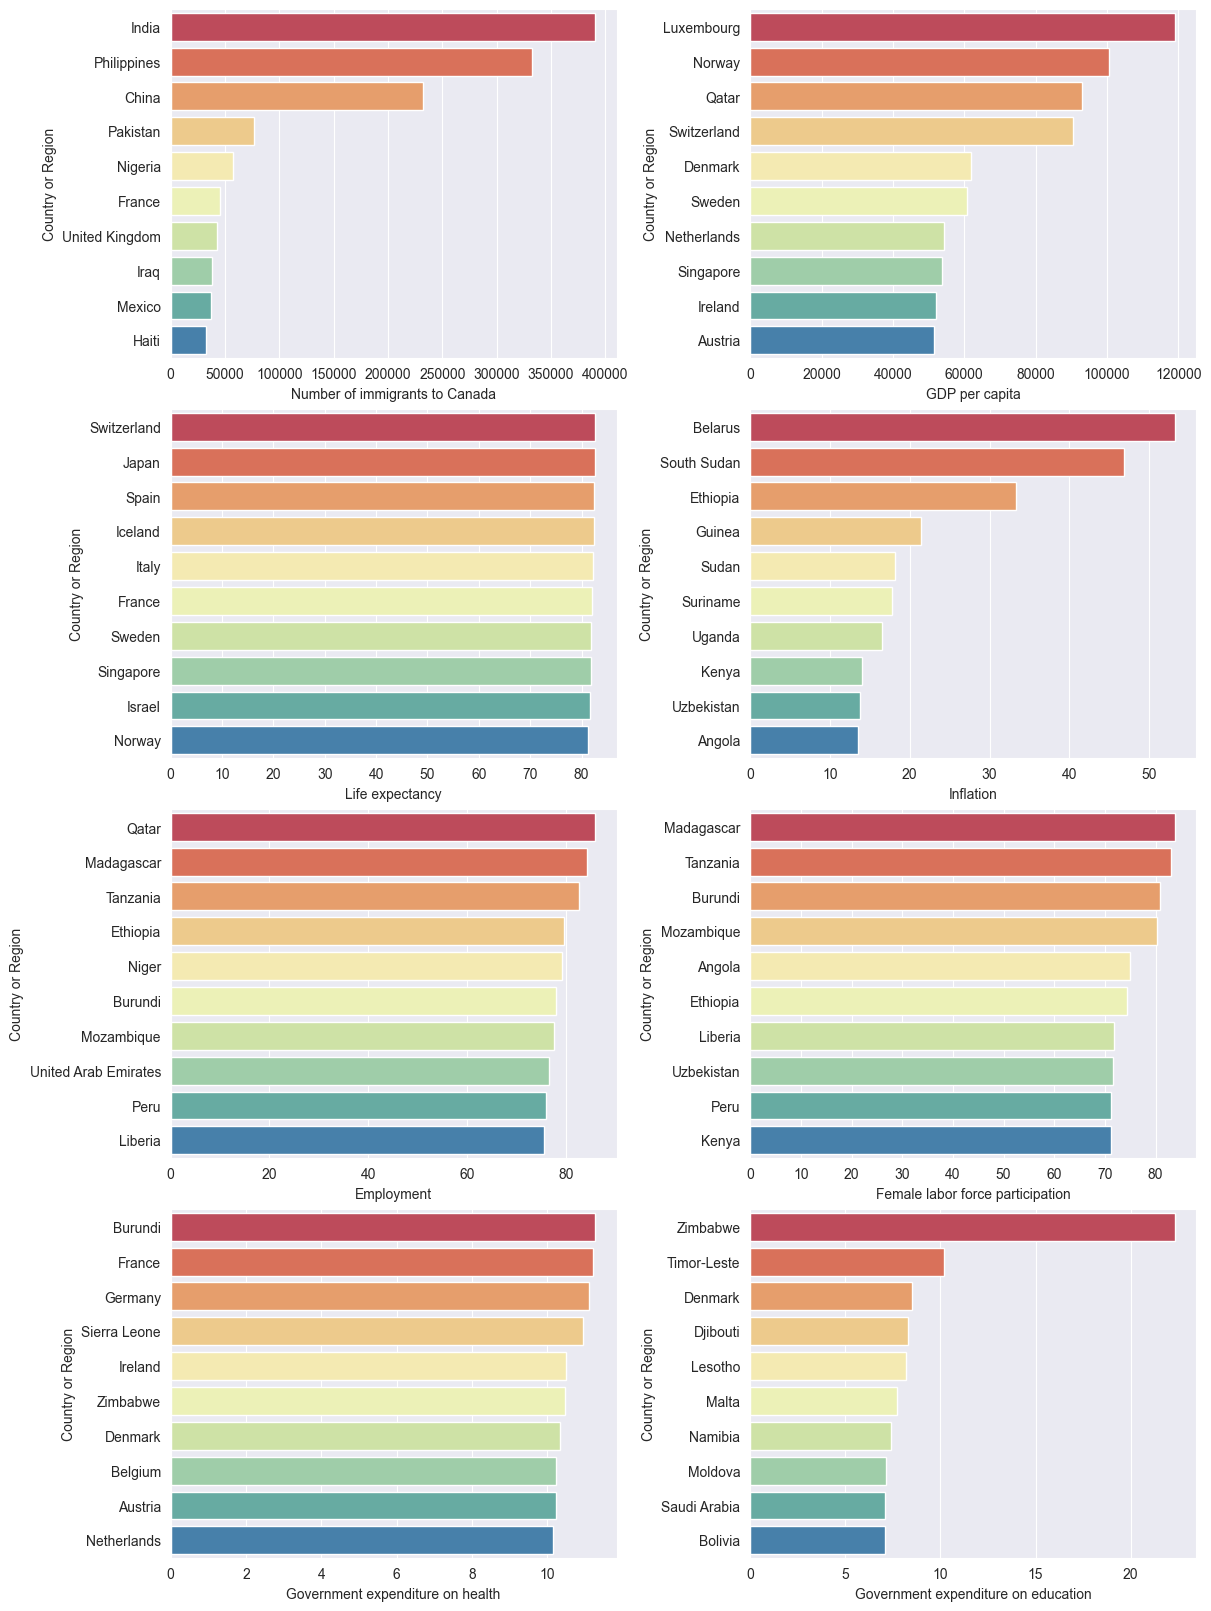

In [29]:
# Display bar graphs for relevant data.
fig, axes = plt.subplots(nrows=4, ncols=2, constrained_layout=True, figsize=(12,16))

sb.barplot(x='Immigration', y='Birthplace', data=dataset.nlargest(10, 'Immigration'), ax=axes[0,0], palette="Spectral")\
    .set(xlabel='Number of immigrants to Canada', ylabel='Country or Region')

sb.barplot(x='GDP' ,y='Birthplace', data=dataset.nlargest(10, 'GDP'), ax=axes[0,1], palette="Spectral")\
    .set(xlabel='GDP per capita', ylabel='Country or Region')

sb.barplot(x='LE',y='Birthplace', data=dataset.nlargest(10, 'LE'), ax=axes[1,0], palette="Spectral")\
    .set(xlabel='Life expectancy', ylabel='Country or Region')

sb.barplot(x='IF' ,y='Birthplace', data=dataset.nlargest(10, 'IF'), ax=axes[1,1], palette="Spectral")\
    .set(xlabel='Inflation', ylabel='Country or Region')

sb.barplot(x='EM',y='Birthplace', data=dataset.nlargest(10, 'EM'), ax=axes[2,0], palette="Spectral")\
    .set(xlabel='Employment', ylabel='Country or Region')

sb.barplot(x='FM',y='Birthplace', data=dataset.nlargest(10, 'FM'), ax=axes[2,1], palette="Spectral")\
    .set(xlabel='Female labor force participation', ylabel='Country or Region')

sb.barplot(x='HE' ,y='Birthplace', data=dataset.nlargest(10, 'HE'), ax=axes[3,0], palette="Spectral")\
    .set(xlabel='Government expenditure on health', ylabel='Country or Region')

sb.barplot(x='ED',y='Birthplace', data=dataset.nlargest(10, 'ED'), ax=axes[3,1], palette="Spectral")\
    .set(xlabel='Government expenditure on education', ylabel='Country or Region')

In [30]:
# Normalize so that the data falls between 0 and 1.

nor = normalize([dataset['Immigration']])
dataset['Immigration'] = nor[0][:]

nor = normalize([dataset['GDP']])
dataset['GDP'] = nor[0][:]

nor = normalize([dataset['LE']])
dataset['LE'] = nor[0][:]

nor = normalize([dataset['IF']])
dataset['IF'] = nor[0][:]

nor = normalize([dataset['EM']])
dataset['EM'] = nor[0][:]

nor = normalize([dataset['FM']])
dataset['FM'] = nor[0][:]

nor = normalize([dataset['HE']])
dataset['HE'] = nor[0][:]

nor = normalize([dataset['ED']])
dataset['ED'] = nor[0][:]

dataset.head()

,Birthplace,Immigration,GDP,LE,IF,EM,FM,HE,ED
0,Afghanistan,0.036369,0.002014,0.073891,0.019503,0.063525,0.025526,0.109438,0.058556
1,Albania,0.009373,0.014369,0.093950,0.030699,0.076295,0.084851,0.058772,0.052095
2,Algeria,0.055525,0.017725,0.089175,0.040503,0.055442,0.024033,0.065348,0.101990
3,Angola,0.000988,0.014609,0.069292,0.120702,0.105378,0.121084,0.034418,0.051249
4,Armenia,0.003613,0.011214,0.088191,0.068487,0.080505,0.089720,0.117940,0.053175


In [31]:
dataset.describe()

,Immigration,GDP,LE,IF,EM,FM,HE,ED
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,0.024245,0.047853,0.084435,0.058617,0.083485,0.081790,0.079212,0.075312
std,0.081897,0.070658,0.010859,0.061954,0.016691,0.023683,0.031287,0.039824
min,0.000017,0.000766,0.056173,-0.003581,0.035349,0.019376,0.023883,0.007888
25%,0.001506,0.004854,0.076133,0.029539,0.073265,0.070475,0.053915,0.051848
50%,0.004810,0.017601,0.087105,0.044535,0.083890,0.084747,0.076626,0.073924
75%,0.012637,0.053058,0.092553,0.070039,0.093230,0.095008,0.104970,0.093696
max,0.666311,0.385457,0.099488,0.476532,0.126531,0.135534,0.144004,0.377554


2 clusters, the silhouette score is 0.8599759949650615
3 clusters, the silhouette score is 0.7281411148758572
4 clusters, the silhouette score is 0.7182283833708076
5 clusters, the silhouette score is 0.5552912635176751
6 clusters, the silhouette score is 0.6093592993668221


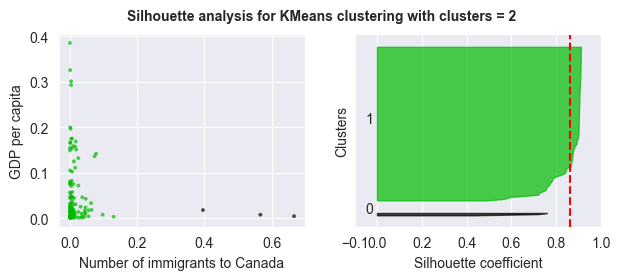

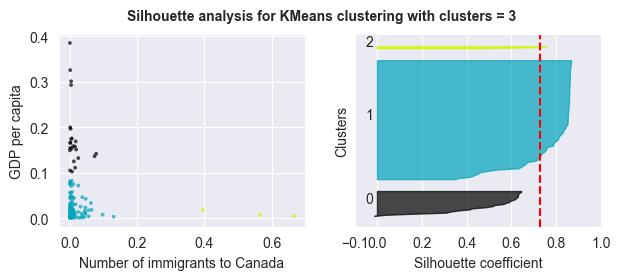

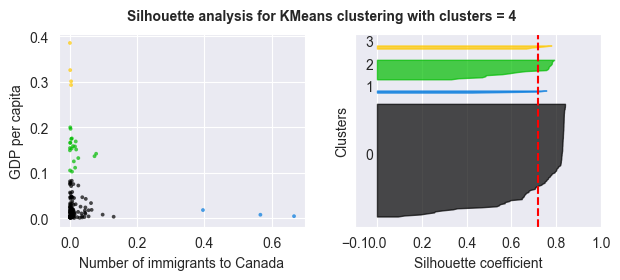

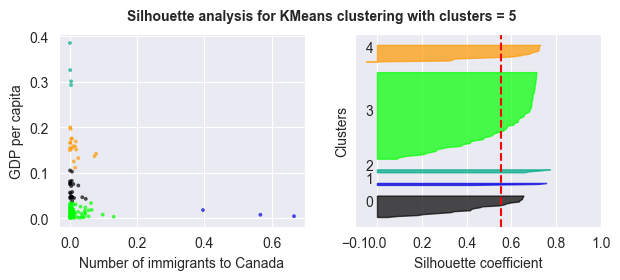

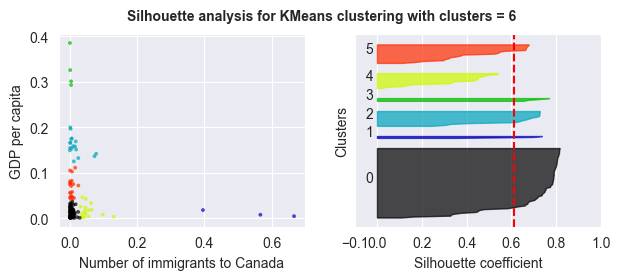

In [32]:
'''
Perform Kmeans clustering on the dataset, calculate the silhouette coefficients, and draw the silhouette plots.
The code used to draw the silhouette plots is from scikit-learn:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

The results and silhouette plots from 2 clusters to 6 clusters are shown separately.
In order to find the most suitable number of clusters for clustering.
'''

for i in range(2, 7):
    X1 = pd.DataFrame({'Immigration':dataset['Immigration'], 'GDP':dataset['GDP']}).to_numpy()
    c1 = KMeans(n_clusters=i, random_state=0, n_init=10)
    label1 = c1.fit_predict(X1)
    silhouette = silhouette_score(X1, label1)
    print(i, 'clusters, the silhouette score is', silhouette)

    sample_silhouette = silhouette_samples(X1, label1)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(7, 2.5)
    ax2.set_xlim([-0.1, 1])
    ax2.set_ylim([0, len(X1) + (i + 1) * 10])
    y_lower = 10

    for n in range(i):
        cluster_silhouette_values = sample_silhouette[label1 == n]
        cluster_silhouette_values.sort()
        cluster_size = cluster_silhouette_values.shape[0]
        y_upper = y_lower + cluster_size
        color = cm.nipy_spectral(n / i)
        ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax2.text(-0.05, y_lower + 0.5 * cluster_size, str(n))
        y_lower = y_upper + 10

    ax2.set_xlabel("Silhouette coefficient")
    ax2.set_ylabel("Clusters")
    ax2.axvline(x=silhouette, color="red", linestyle="--")
    ax2.set_yticks([])
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(label1.astype(float) / i)
    ax1.scatter(X1[:, 0], X1[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
    ax1.set_xlabel("Number of immigrants to Canada")
    ax1.set_ylabel("GDP per capita")
    plt.suptitle("Silhouette analysis for KMeans clustering with clusters = %d" % i, fontsize=10, fontweight="bold",)

plt.show()

In [33]:
# By comparing the silhouette coefficients to find the most suitable number of clusters.
def choose_cluster(table):
    score = 0
    n = 0

    for i in range(2, 7):
        c = KMeans(n_clusters=i, random_state=0, n_init=10)
        label = c.fit_predict(table)
        sil = silhouette_score(table, label)

        if sil > score:
            score = sil
            n = i

    print(n, 'clusters, the silhouette score is', score)
    return n

# Perform Kmeans clustering and output the clustering results for each cluster (by country).
def plot_cluster(table, n, x_label):
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    cx = KMeans(n_clusters=n, random_state=0, n_init=10).fit_predict(table)
    plt.figure(figsize=(4,3))

    for j in range(n):
        plt.scatter(table[cx==j, 0], table[cx==j, 1], s=10, c=color[j], label ='Cluster %d'% (j + 1))
        group = []

        for k in range(len(a0)):
            if cx[k] == j:
                group.append(a0[k])

        print('Cluster %d:'% (j + 1), group)
        group.clear()

    plt.xlabel(x_label)
    plt.ylabel('Immigrants')
    plt.legend()
    plt.show()

2 clusters, the silhouette score is 0.8599759949650615
Cluster 1: ['China', 'India', 'Philippines']
Cluster 2: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Mal

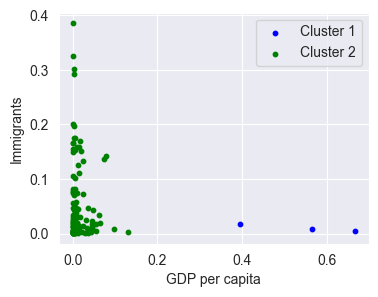

In [34]:
# Clustering using the change in GDP per capita from 2011 to 2021 with the number of immigrants to Canada in this decade.
X1 = pd.DataFrame({'Immigration':dataset['Immigration'], 'GDP':dataset['GDP']}).to_numpy()
plot_cluster(X1, choose_cluster(X1), 'GDP per capita')

2 clusters, the silhouette score is 0.9450323433569652
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta'

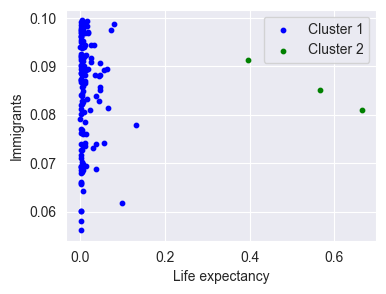

In [35]:
# Clustering using the change in life expectancy from 2011 to 2021 with the number of immigrants to Canada in this decade.
X2 = pd.DataFrame({'Immigration':dataset['Immigration'], 'LE':dataset['LE']}).to_numpy()
plot_cluster(X2, choose_cluster(X2), 'Life expectancy')

2 clusters, the silhouette score is 0.8857482657537894
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta'

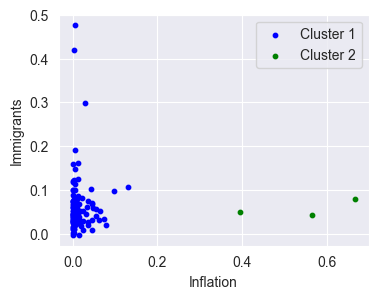

In [36]:
X3 = pd.DataFrame({'Immigration':dataset['Immigration'], 'IF':dataset['IF']}).to_numpy()
plot_cluster(X3, choose_cluster(X3), 'Inflation')

2 clusters, the silhouette score is 0.9355168841932309
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta'

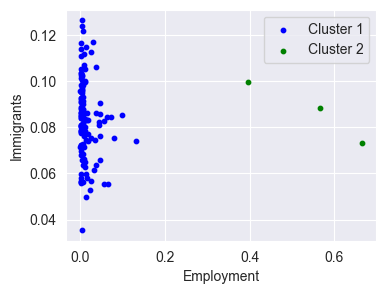

In [37]:
X4 = pd.DataFrame({'Immigration':dataset['Immigration'], 'EM':dataset['EM']}).to_numpy()
plot_cluster(X4, choose_cluster(X4), 'Employment')

2 clusters, the silhouette score is 0.9249966475304442
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta'

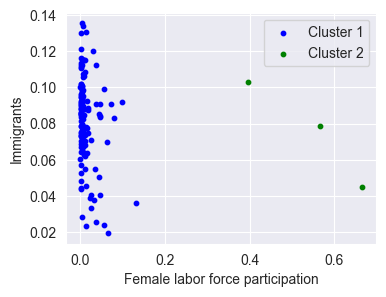

In [38]:
X5 = pd.DataFrame({'Immigration':dataset['Immigration'], 'FM':dataset['FM']}).to_numpy()
plot_cluster(X5, choose_cluster(X5), 'Female labor force participation')

2 clusters, the silhouette score is 0.9087125506223479
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta'

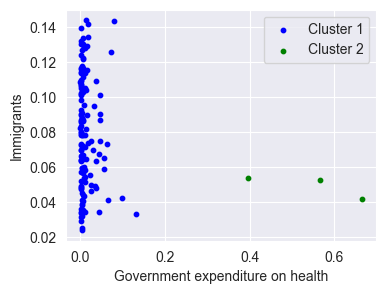

In [39]:
X6 = pd.DataFrame({'Immigration':dataset['Immigration'], 'HE':dataset['HE']}).to_numpy()
plot_cluster(X6, choose_cluster(X6), 'Government expenditure on health')

2 clusters, the silhouette score is 0.9046690129435767
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta'

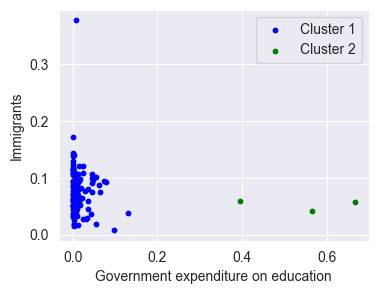

In [40]:
X7 = pd.DataFrame({'Immigration':dataset['Immigration'], 'ED':dataset['ED']}).to_numpy()
plot_cluster(X7, choose_cluster(X7), 'Government expenditure on education')

2 clusters, the silhouette score is 0.7500465006144879
Cluster 1: ['China', 'India', 'Philippines']
Cluster 2: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Mal

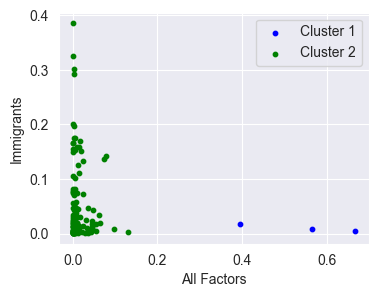

In [41]:
# Clustering with all other indicators using immigrants data.
X8 = dataset.drop(['Birthplace'], axis=1).to_numpy()
plot_cluster(X8, choose_cluster(X8), 'All Factors')

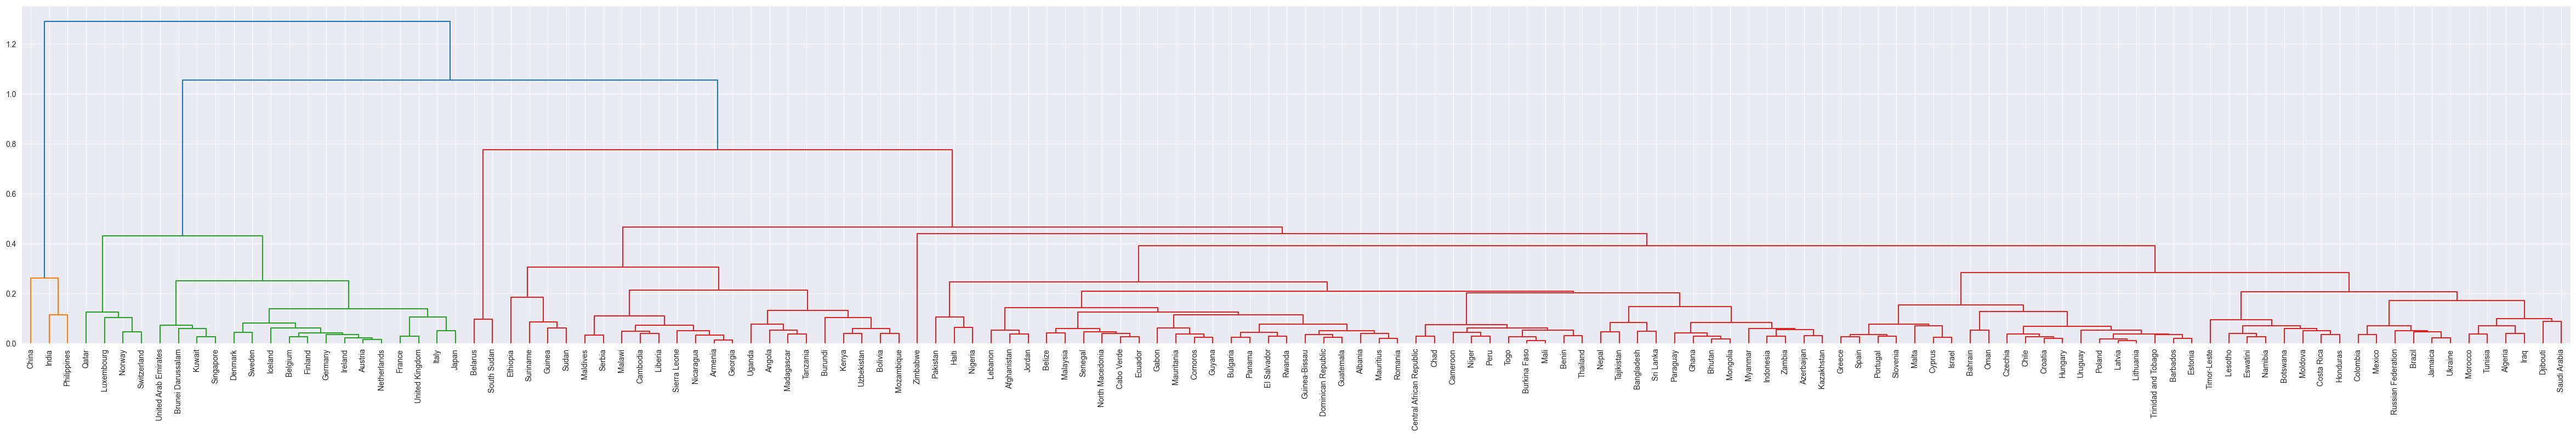

In [42]:
# Hierarchical clustering using the entire dataset.
comb_data = dataset.drop(['Birthplace'], axis=1)
plt.figure(figsize=(60, 8))
dend=sch.dendrogram(sch.linkage(comb_data,method='ward'), labels=a0, leaf_font_size=10)

### End of Experiments.